In [273]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
import statsmodels.discrete.discrete_model as dm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

In [4]:
df = pd.read_csv('data/gdp_pop_climate_gfsi.csv')

In [19]:
migration = pd.read_csv('data/migration_all_9020.csv')

In [23]:
migration = migration[['country-code', 'year',
       'migration']]

In [28]:
df = df.merge(migration, on=['country-code', 'year'])

In [334]:
df_codes = pd.read_csv('data/countryCode_to_region.csv')

In [336]:
df_codes = df_codes[['name','country-code', 'region']]

In [355]:
df = df.merge(df_codes, on=['country-code'])

In [339]:
cols = ['migration']
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in cols:
    df[col] = min_max_scaling(df[col])

In [340]:
df.to_csv('data/gdp_pop_clm_mig_gfsi.csv')

In [341]:
cols = ['gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']
for i in cols:
    print(i + ':  ' + 'Mean='+str(np.mean(df[i])) + ' Variance='+str(np.var(df[i])))

gfsi:  Mean=0.5292334848711926 Variance=0.06565634954683562
surfacetempanomaly:  Mean=0.745075687423928 Variance=0.06168207302896382
precipitationflux:  Mean=0.3311981827046501 Variance=0.039590906326606286
gdp:  Mean=0.1455352829905088 Variance=0.038637381133571146
population:  Mean=0.04351306894750868 Variance=0.016904328613265723
migration:  Mean=0.10240533841936852 Variance=0.019717775633480754


Not suiteable for a poisson regression model given the above

## Feature Selection:

Text(0.5, 1.0, 'Correlation HeatMap')

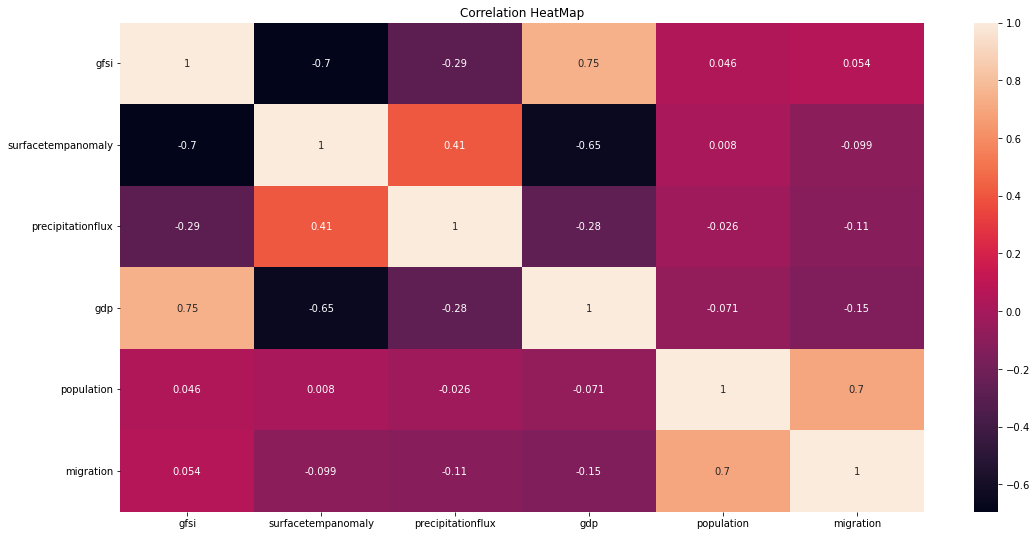

In [107]:
correl = df[['year', 'country-code', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].set_index(['year', 'country-code'])
ax, fig = plt.subplots(figsize =(18,9))
sns.heatmap(correl.corr(), annot = True)
plt.title("Correlation HeatMap")

,Country,country-code,region-code,sub-region-code,year,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
0,Algeria,12,2.0,15.0,2012,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
1,Algeria,12,2.0,15.0,2013,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2,Algeria,12,2.0,15.0,2014,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
3,Algeria,12,2.0,15.0,2015,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
4,Algeria,12,2.0,15.0,2016,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...,...,...,...,...
994,Zambia,716,2.0,202.0,2016,0.207024,0.899491,0.457260,0.012040,0.008511,0.065035
995,Zambia,716,2.0,202.0,2017,0.127542,0.906662,0.431102,0.009806,0.008657,0.065890
996,Zambia,716,2.0,202.0,2018,0.199630,0.922352,0.578945,0.009996,0.008801,0.066744
997,Zambia,716,2.0,202.0,2019,0.184843,0.905446,0.469995,0.010601,0.008947,0.067599


In [356]:
df_pairs = df[df.year > 2017].groupby('country-code').mean()

In [357]:
df_pairs = df_pairs.reset_index()

In [359]:
df_pairs = df_pairs.merge(df_codes, on='country-code')

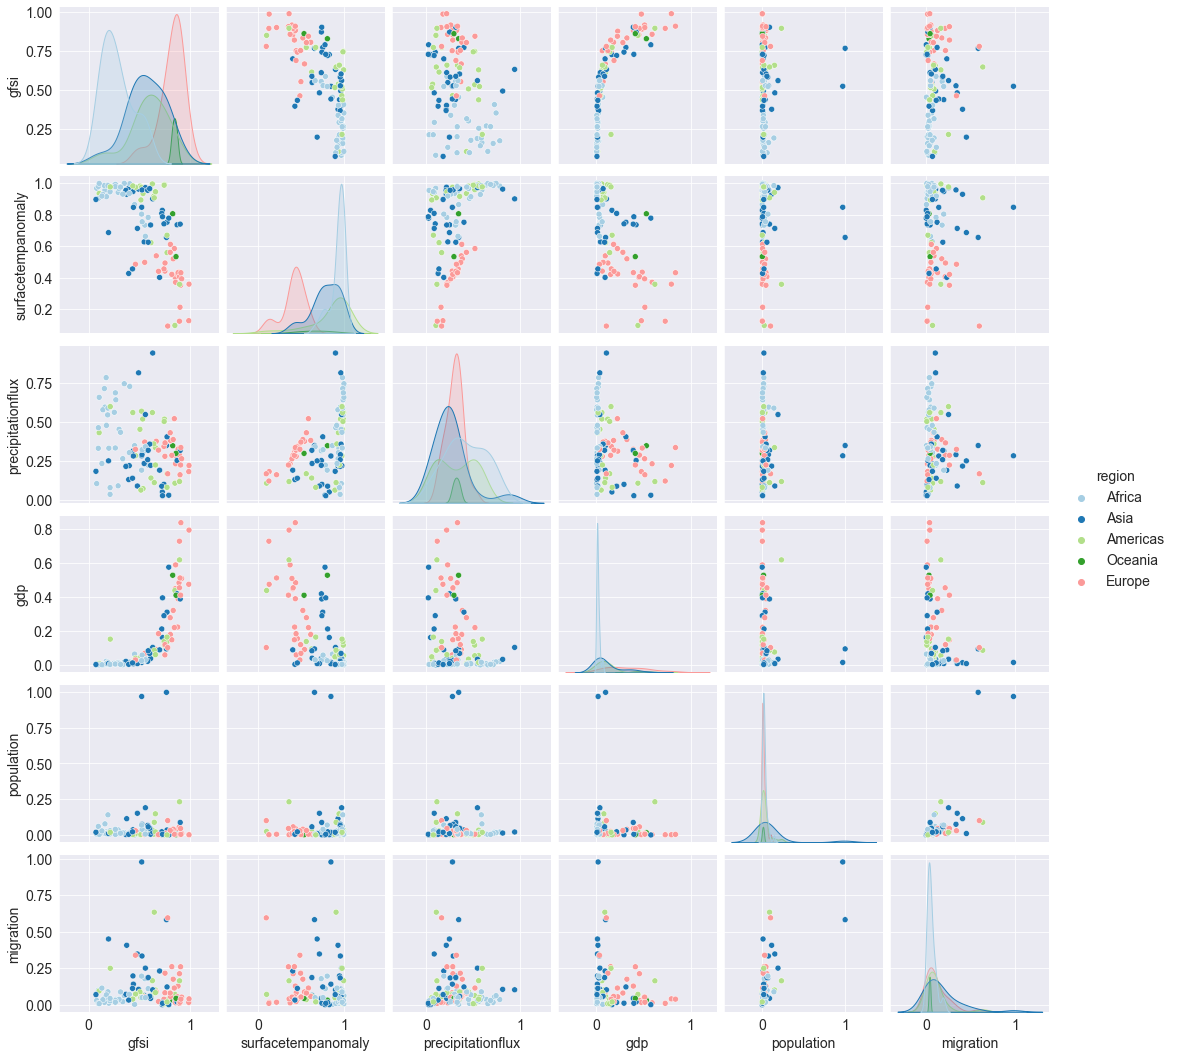

In [360]:
z = df_pairs.loc[:,['region', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']]
sns.pairplot(z, hue='region', palette="Paired")

In [361]:
y = df['gfsi']
X = df[['surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']]

function_dict = {'predictor': [], 'r-squared':[]}
for col in X.columns:
    selected_X = X[[col]]
    model = sm.OLS(y, sm.add_constant(selected_X)).fit()
    y_preds = model.predict(sm.add_constant(selected_X))
    function_dict['predictor'].append(col)
    r2 = np.corrcoef(y, y_preds)[0, 1]**2
    function_dict['r-squared'].append(r2)
    
function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'], ascending = False)

display(function_df.head())

,predictor,r-squared
2,gdp,0.555463
0,surfacetempanomaly,0.483169
1,precipitationflux,0.081702
4,migration,0.002931
3,population,0.002089


In [67]:
def next_possible_feature (X_npf, y_npf, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. 
    It will display a dataframe with a sorted r-squared value.
    X_npf = X dataframe
    y_npf = y dataframe
    current_features = list of features that are already in your model
    ignore_features = list of unused features we want to skip over
    '''   
    function_dict = {'predictor': [], 'r-squared':[]}

    for col in X_npf.columns:
        if col not in (current_features+ignore_features):
            selected_X = X_npf[current_features + [col]]
            model = sm.OLS(y_npf, sm.add_constant(selected_X)).fit()
            y_preds = model.predict(sm.add_constant(selected_X))
            function_dict['predictor'].append(col)
            r2 = np.corrcoef(y_npf, y_preds)[0, 1]**2
            function_dict['r-squared'].append(r2)
    function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'],\
                                                          ascending = False)
    display(function_df.head())

In [367]:
X = df[['surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']]
y = df.gfsi
model = sm.OLS(y, sm.add_constant(X)).fit()

In [368]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   gfsi   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     358.9
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          1.14e-219
Time:                        23:50:01   Log-Likelihood:                 458.38
No. Observations:                 999   AIC:                            -904.8
Df Residuals:                     993   BIC:                            -875.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6645      0.026     25.388      0.000       0.613       0.716
surfacetempanomaly    -0.3524      0.028    -12.541      0.000      -0.408      -0.297
precipitationflux      0.0186      0.027      0.694      0.488      -0.034       0.071
gdp                    0.7078      0.034     20.638      0.000       0.640       0.775
population             0.0578      0.053      1.087      0.278      -0.047       0.162
migration              0.1521      0.052      2.945      0.003       0.051       0.253
==============================================================================
Omnibus:                       64.948   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.503
Skew:                          -0.230   Prob(JB):                     2.38e-07
Kurtosis:                       2.278   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see the signifcant variables are surfacetempanomaly, gdp, and migration.

plot observations with confidence intervals

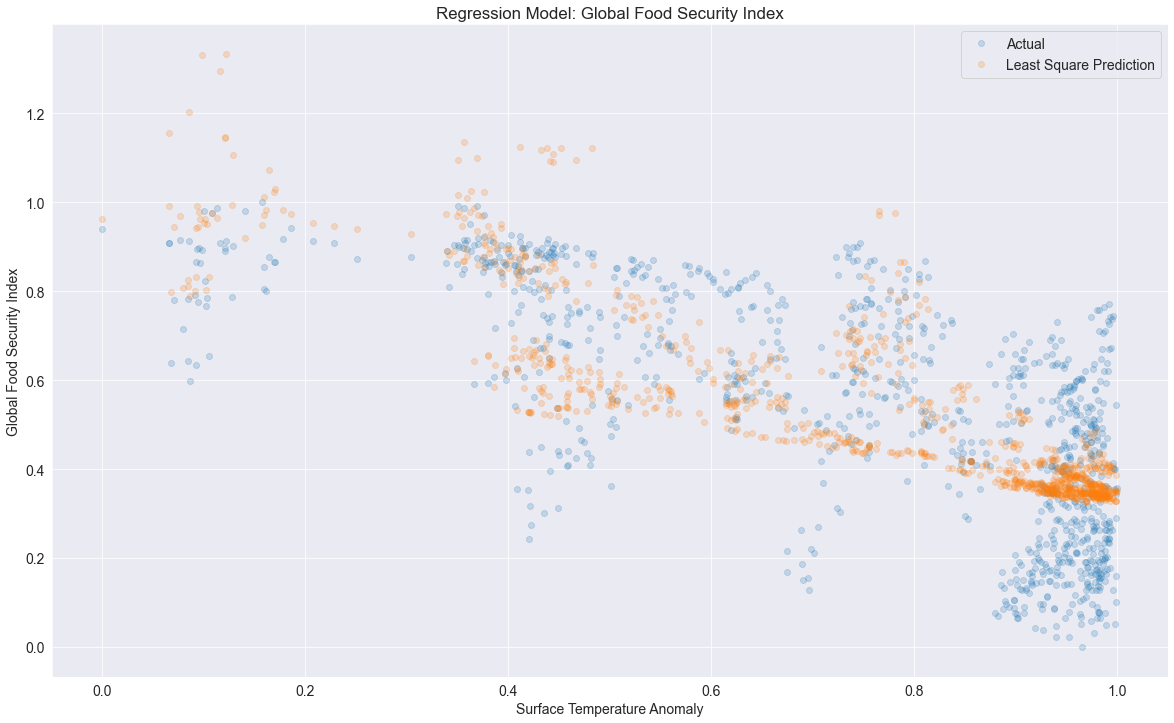

In [386]:
pred_ols = model.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(X.surfacetempanomaly, y, "o", alpha=0.2, label="Actual")
ax.plot(X.surfacetempanomaly, model.fittedvalues, "o", alpha=0.2, label="Least Square Prediction")
ax.set_ylabel('Global Food Security Index')
ax.set_xlabel('Surface Temperature Anomaly')
ax.set_title('Regression Model: Global Food Security Index')
ax.legend(loc="best")



In [332]:
df_in.head(100)

,country-code,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
year,,,,,,,
2012-01-01,12,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
2013-01-01,12,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2014-01-01,12,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
2015-01-01,12,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
2016-01-01,12,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...
2017-01-01,68,0.552680,0.935668,0.069752,0.030412,0.006497,0.047273
2018-01-01,68,0.556377,0.925000,0.078679,0.032335,0.006611,0.048430
2019-01-01,68,0.539741,0.943475,0.064354,0.032369,0.006724,0.049587


In [117]:
selected_features = ['surfacetempanomaly']
features_to_ignore = []
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features, ignore_features=[features_to_ignore])

,predictor,r-squared
1,gdp,0.633360
2,population,0.485798
3,migration,0.483397
0,precipitationflux,0.483176


In [118]:
vif_3 = pd.DataFrame()
X_3 = X[['surfacetempanomaly', 'gdp']]
vif_3["features"] = X_3.columns
vif_3["VIF"] = [variance_inflation_factor(X_3.values, i) \
                for i in range(len(X_3.columns))]
vif_3

,features,VIF
0,surfacetempanomaly,1.190516
1,gdp,1.190516


## Regression

In [119]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [120]:
dfs = df[['year', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].groupby('year').mean()

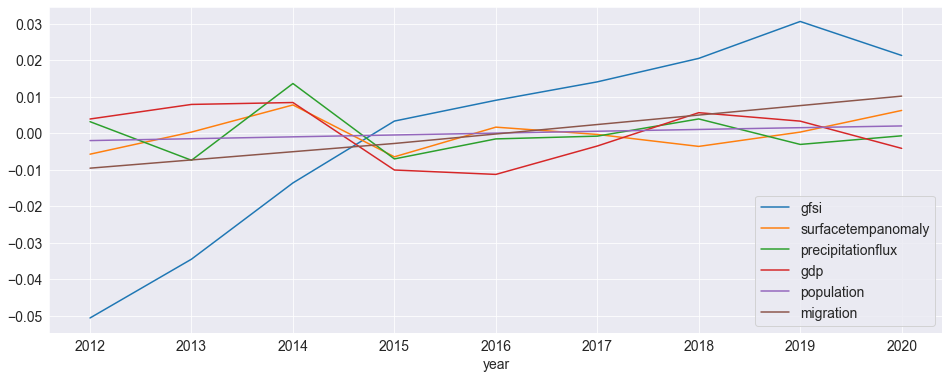

In [121]:
_ = (dfs - dfs.mean()).plot()

In [248]:
df_in = df[['year', 'country-code', 'gfsi', 'surfacetempanomaly', 'precipitationflux', 'gdp', 'population', 'migration']].set_index(['year'])

In [249]:
df_in.index = pd.to_datetime(df_in.index, format='%Y')

In [250]:
df_in

,country-code,gfsi,surfacetempanomaly,precipitationflux,gdp,population,migration
year,,,,,,,
2012-01-01,12,0.408503,0.809657,0.216945,0.052237,0.025087,0.095596
2013-01-01,12,0.373383,0.792927,0.248590,0.051335,0.025623,0.097627
2014-01-01,12,0.486137,0.807242,0.255665,0.051272,0.026180,0.099658
2015-01-01,12,0.500924,0.809971,0.315983,0.038464,0.026750,0.101689
2016-01-01,12,0.587800,0.784674,0.249411,0.036210,0.027335,0.103771
...,...,...,...,...,...,...,...
2016-01-01,716,0.207024,0.899491,0.457260,0.012040,0.008511,0.065035
2017-01-01,716,0.127542,0.906662,0.431102,0.009806,0.008657,0.065890
2018-01-01,716,0.199630,0.922352,0.578945,0.009996,0.008801,0.066744


In [ ]:
res = sel_res.model.fit()
print(res.summary())

                              ARDL Model Results                              
Dep. Variable:                   gfsi   No. Observations:                  999
Model:                  ARDL(1, 1, 1)   Log Likelihood                1105.301
Method:               Conditional MLE   S.D. of innovations              0.080
Date:                Wed, 08 Jun 2022   AIC                          -2196.602
Time:                        01:55:25   BIC                          -2162.262
Sample:                             1   HQIC                         -2183.550
                                  999                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0955      0.017      5.609      0.000       0.062       0.129
gfsi.L1                   0.8563      0.016     52.302      0.000       0.824       0.888
surfacet

In [252]:
sel_res = ardl_select_order(
    df_in.gfsi, 3, df_in[['surfacetempanomaly', 'gdp']], 3, ic="aic", trend="c"
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (1, 1, 1)


/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provid

In [254]:
sel_res = ardl_select_order(
    df_in.gfsi, 3, df_in[['surfacetempanomaly', 'gdp']], 3, ic="bic", trend="c", glob=True
)
sel_res.model.ardl_order

/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provid

(1, 1, 1)

In [255]:
sel_res.model.ar_lags

[1]

In [256]:
def predictgfsi(dftemp):
    sel_res = ardl_select_order(
        dftemp.gfsi, 3, dftemp[['surfacetempanomaly', 'gdp']], 3, ic="bic", trend="c", glob=True
    )
    sel_res.model.ardl_order
    sel_res.model.dl_lags
    res = sel_res.model.fit()
    return res

{'surfacetempanomaly': [0, 1], 'gdp': [0, 1]}

In [257]:
for i, val in enumerate(sel_res.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
2: ((1, 3), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
3: ((1, 2), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1)})
4: ((1,), {'surfacetempanomaly': (0, 1, 2), 'gdp': (0, 1)})
5: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 2)})
6: ((1,), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})
7: ((1,), {'surfacetempanomaly': (0, 1, 3), 'gdp': (0, 1)})
8: ((1, 3), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})
9: ((1, 3), {'surfacetempanomaly': (0, 1, 3), 'gdp': (0, 1)})
10: ((1, 2), {'surfacetempanomaly': (0, 1), 'gdp': (0, 1, 3)})


In [258]:
res = sel_res.model.fit()
print(res.summary())

                              ARDL Model Results                              
Dep. Variable:                   gfsi   No. Observations:                  999
Model:                  ARDL(1, 1, 1)   Log Likelihood                1105.301
Method:               Conditional MLE   S.D. of innovations              0.080
Date:                Wed, 08 Jun 2022   AIC                          -2196.602
Time:                        01:55:25   BIC                          -2162.262
Sample:                             1   HQIC                         -2183.550
                                  999                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0955      0.017      5.609      0.000       0.062       0.129
gfsi.L1                   0.8563      0.016     52.302      0.000       0.824       0.888
surfacet

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


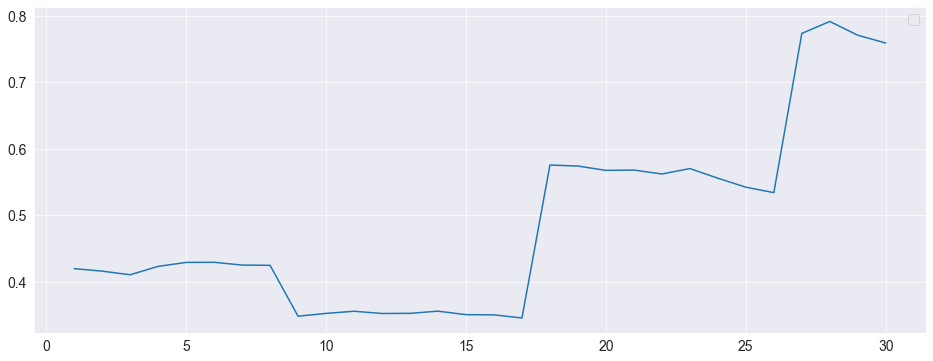

In [259]:
fig = res.plot_predict(1, 30, True)



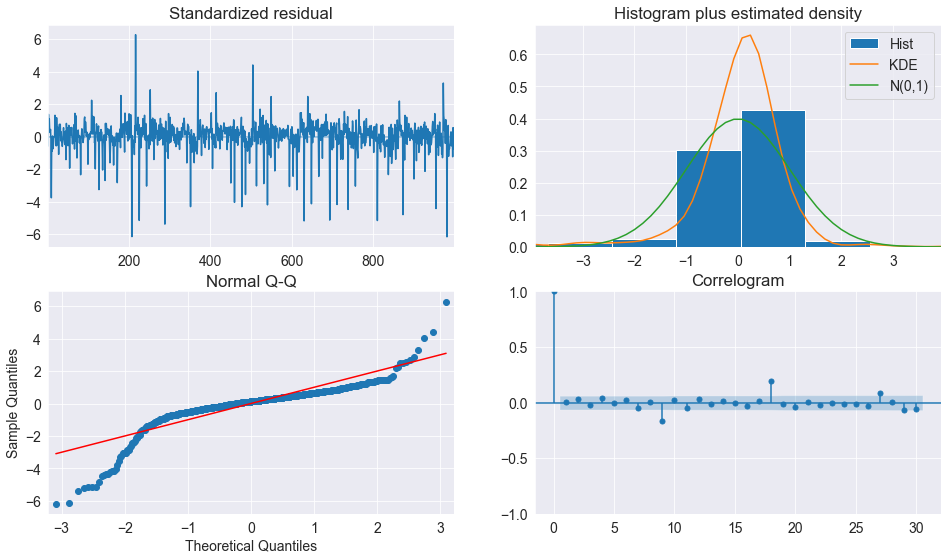

In [260]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [328]:
from sklearn.metrics import mean_squared_error
from math import sqrt

dff_in = df_in[df_in['country-code'] == 12]
history = [x for x in dff_in]
predictions = list()
# walk-forward validation
for t in range(len(dff_in)):
	output = res.forecast(exog=dff_in[t:t+1][['surfacetempanomaly', 'gdp']])
	yhat = output
	predictions.append(yhat)
	obs = dff_in[t:t+1].gfsi
	history.append(obs)
rmse = sqrt(mean_squared_error(dff_in.gfsi, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.285


/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/si

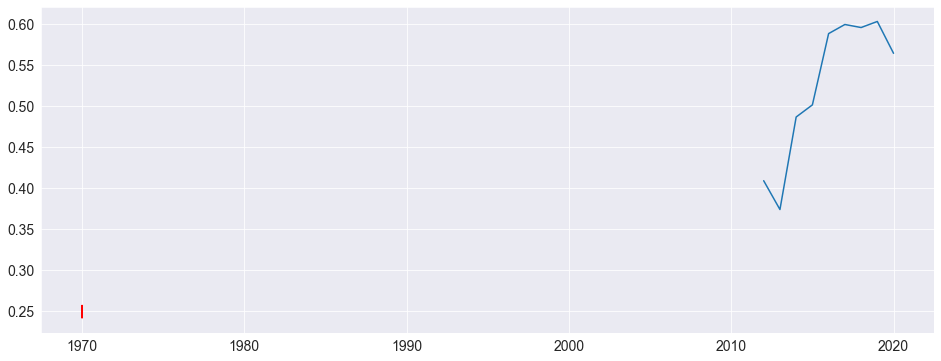

In [329]:
from matplotlib import pyplot
pyplot.plot(dff_in.gfsi)
pyplot.plot(predictions, color='red')
pyplot.show()

In [321]:
df_in.index.values.shape

AttributeError: 'list' object has no attribute 'shape'

In [323]:
preds = pd.DataFrame(predictions)

In [326]:
preds.columns

RangeIndex(start=999, stop=1000, step=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


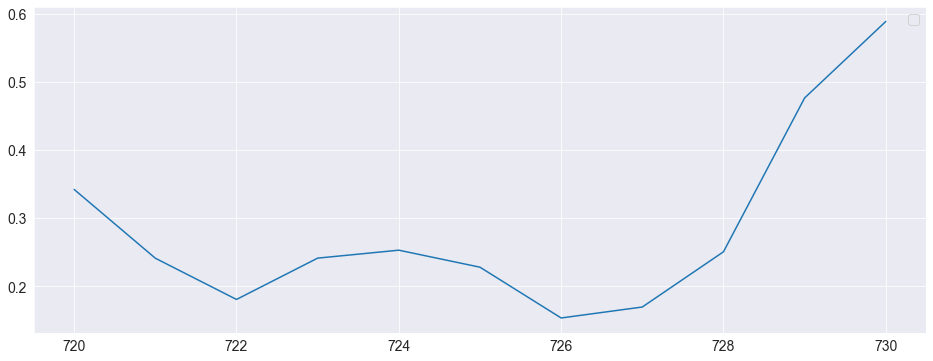

In [279]:
fig = res.plot_predict(720, 730)

In [272]:
start = df_in.index[-90]
print(df_in.index.year)

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2012,
            ...
            2020, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='year', length=999)


In [270]:
pd.date_range(2012, freq=df_in.index.freq, periods=12)

ValueError: Invalid frequency: DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2012-01-01',
               ...
               '2020-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='year', length=999, freq=None)

In [278]:
def predictgfsi(dftemp):
    sel_res = ardl_select_order(
        dftemp.gfsi, 3, dftemp[['surfacetempanomaly', 'gdp']], 3, ic="bic", trend="c", glob=True
    )
    sel_res.model.ardl_order
    sel_res.model.dl_lags
    res = sel_res.model.fit()
    return res

In [277]:
set(df_in['country-code'])

{12,
 24,
 31,
 32,
 36,
 40,
 50,
 56,
 68,
 72,
 76,
 100,
 104,
 108,
 112,
 116,
 120,
 124,
 144,
 148,
 152,
 156,
 170,
 180,
 188,
 203,
 204,
 208,
 214,
 218,
 222,
 231,
 246,
 250,
 276,
 288,
 300,
 320,
 324,
 332,
 340,
 348,
 356,
 360,
 372,
 376,
 380,
 384,
 392,
 398,
 400,
 404,
 410,
 414,
 418,
 450,
 454,
 458,
 466,
 484,
 504,
 508,
 512,
 524,
 528,
 554,
 558,
 562,
 566,
 578,
 586,
 591,
 600,
 604,
 608,
 616,
 620,
 634,
 642,
 643,
 646,
 682,
 686,
 688,
 694,
 703,
 704,
 710,
 716,
 724,
 729,
 752,
 756,
 760,
 762,
 764,
 768,
 784,
 788,
 792,
 800,
 804,
 818,
 826,
 834,
 840,
 854,
 858,
 860,
 862,
 887}

In [280]:

country_codes = set(df_in['country-code'])
for i in country_codes: 
    dff = df_in[df_in['country-code'] == i]
    restemp = predictgfsi(dff)
    fig = restemp.plot_predict(720, 730)
    

/opt/homebrew/Caskroom/miniconda/base/envs/dskus3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


ValueError: The number of regressors (12) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (6).

In [ ]:
df_in